In [65]:
import shutil
import os

if os.path.exists("logs"):
    shutil.rmtree("logs")
    print("Logs directory cleared")
else:
    print("No logs directory found")

Logs directory cleared


In [66]:
from utils import start_tensorboard

start_tensorboard()

⚠️  Warning: Logs directory not found at /Users/philippgeppner/LectureNotes/exercise_9/logs


# Fully Connected Neural Networks: Part 2 - First Image Classification
After getting to know a basic assortment of layer types and activation functions, we will switch our task to image classification, showing some of the limitations of pure fully connected (dense) neural networks. We will evaluate a moderately deep network with a quite standard layout and do some basic random paramter and achritecture search.


In [67]:
# load data
import keras
import numpy as np
from skimage.transform import resize


sym_dim=8
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0 #this is how we normally scale with images
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0 #same for test


X_train = resize(X_train.reshape(-1, 28, 28), (len(X_train), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")
X_test = resize(X_test.reshape(-1, 28, 28), (len(X_test), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")


X_train: (60000, 64), y_train: (60000,)
X_test: (10000, 64), y_test: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


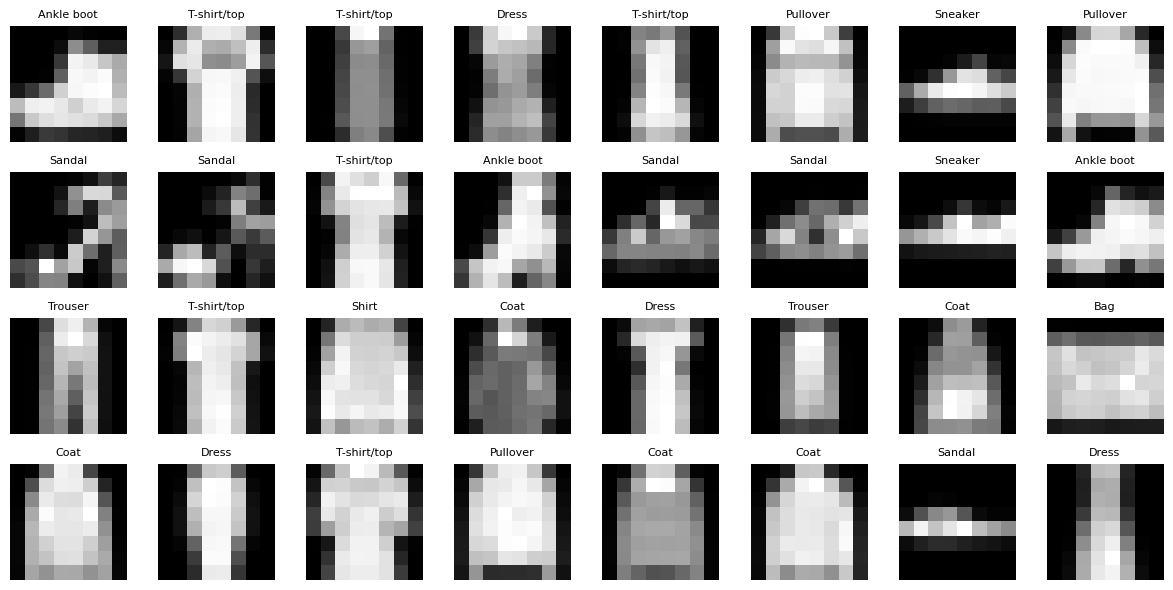

In [68]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(sym_dim, sym_dim), cmap='gray')
    ax.set_title(class_names[y_train[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [69]:
def create_fcnn(
    input_dim: int,
    num_classes: int,
    hidden_layers: list[int] = [512, 256, 128],
    activation: str = "relu",
    dropout_rate: float = 0.3,
    learning_rate: float = 0.001,
    use_batchnorm: bool = True,
    use_skip: bool = False,
    name: str = "fcnn"
) -> keras.Model:
    
    inputs = keras.layers.Input(shape=(input_dim,))
    x = inputs
    skip = None
    
    for i, units in enumerate(hidden_layers):
        if use_skip and i > 0 and skip is not None and i % 2 == 0:
            if skip.shape[-1] != x.shape[-1]:
                skip = keras.layers.Dense(x.shape[-1])(skip)
            x = keras.layers.Add()([x, skip])
        
        if use_skip and i % 2 == 0:
            skip = x
            
        x = keras.layers.Dense(units)(x)
        if use_batchnorm:
            x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation)(x)
        if dropout_rate > 0:
            x = keras.layers.Dropout(dropout_rate)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [70]:
basic_model = create_fcnn(
    input_dim=sym_dim*sym_dim,
    num_classes=10,
    hidden_layers=[512, 256, 128],
    activation="relu",
    dropout_rate=0.3,
    learning_rate=0.001,
    use_batchnorm=True,
    use_skip=False,
    name="fashion_fcnn"
)
basic_model.summary()

Model: "fashion_fcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_57 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_286 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_287         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_287 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_288         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_288 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,378 (790.54 KB)

 Trainable params: 200,586 (783.54 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7572 - loss: 0.6808 - val_accuracy: 0.8213 - val_loss: 0.4774
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8060 - loss: 0.5352 - val_accuracy: 0.8251 - val_loss: 0.4608
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8191 - loss: 0.4942 - val_accuracy: 0.8466 - val_loss: 0.4090
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8271 - loss: 0.4712 - val_accuracy: 0.8471 - val_loss: 0.4156
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8322 - loss: 0.4570 - val_accuracy: 0.8483 - val_loss: 0.4019
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8363 - loss: 0.4426 - val_accuracy: 0.8548 - val_loss: 0.3906
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8406 - loss: 0.4342 - val_accuracy: 0.8525 - val_loss: 0.3936
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8421 - loss: 0.4273 - 

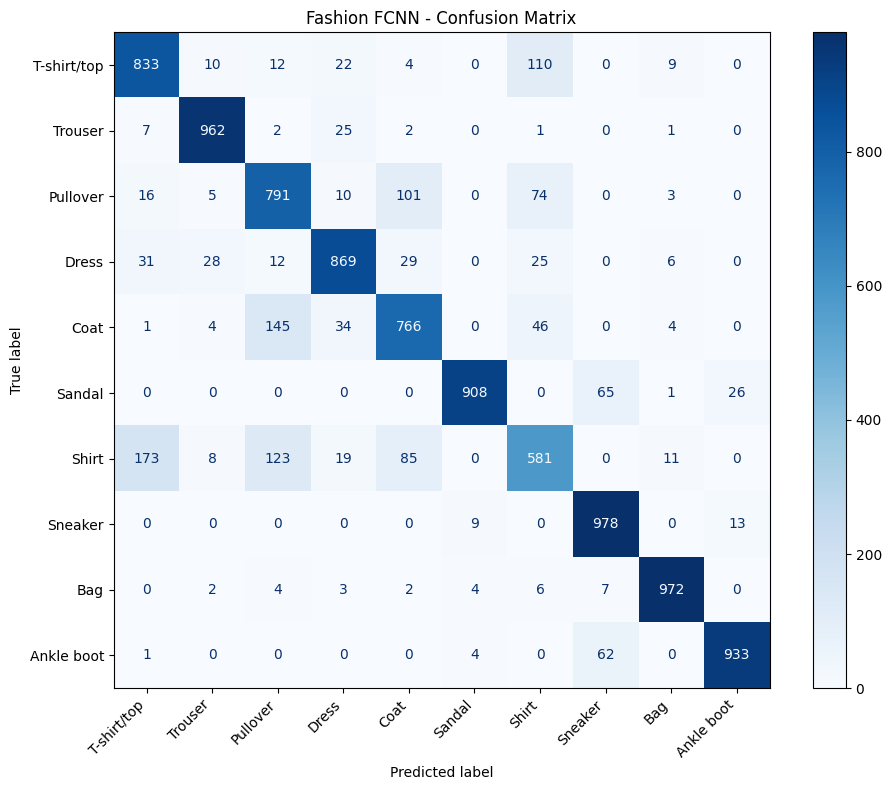

(0.3882372975349426, 0.8593000173568726)

In [71]:
from utils import train_model, eval_classification

basic_fcnn_history = train_model(basic_model, X_train, y_train, "basic_functional_api", epochs=10)
eval_classification(basic_model, X_test, y_test, class_names, "Fashion FCNN")

In [72]:
import random
import pandas as pd

def create_hyperparams(
    n: int,
    num_layers_range: tuple[int, int] = (1, 4),
    units_choices: list[int] = [128, 256, 512],
    dropout_range: tuple[float, float] = (0.1, 0.5),
    lr_range: tuple[float, float] = (1e-4, 1e-2),
    activation_choices: list[str] = ["relu", "elu"],
    batchnorm_choices: list[bool] = [True, False],
    skip_choices: list[bool] = [True, False],
) -> pd.DataFrame:
    
    params_list = []
    for _ in range(n):
        params_list.append({
            "hidden_layers": [random.choice(units_choices) for _ in range(random.randint(*num_layers_range))],
            "dropout_rate": round(random.uniform(*dropout_range), 3),
            "learning_rate": round(10 ** random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])), 6),
            "activation": random.choice(activation_choices),
            "use_batchnorm": random.choice(batchnorm_choices),
            "use_skip": random.choice(skip_choices),
        })
    return pd.DataFrame(params_list)


def run_search(
    hp_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 10,
) -> tuple[keras.Model, dict, pd.DataFrame]:
    
    from utils import train_model
    
    results = hp_df.copy()
    results["val_acc"] = -1.0
    models = {}
    
    for i, row in hp_df.iterrows():
        params = {
            "hidden_layers": row["hidden_layers"],
            "dropout_rate": row["dropout_rate"],
            "learning_rate": row["learning_rate"],
            "activation": row["activation"],
            "use_batchnorm": row["use_batchnorm"],
            "use_skip": row["use_skip"],
        }
        
        model = create_fcnn(input_dim=X_train.shape[1], num_classes=10, name=f"trial_{i}", **params)
        
        layers_str = "_".join(map(str, params["hidden_layers"]))
        model_name = f"rs_{params['activation']}_L{layers_str}_D{int(params['dropout_rate']*100)}"
        
        model, _ = train_model(model, X_train, y_train, model_name=model_name, epochs=epochs, early_stopping=True, verbose=0)
        _, val_acc = model.evaluate(X_train[:10000], y_train[:10000], verbose=0)
        
        results.loc[i, "val_acc"] = round(val_acc, 4)
        models[i] = model
        
        print(f"Trial {i+1}/{len(hp_df)}: acc={val_acc:.4f} | {params['activation']} skip={params['use_skip']} bn={params['use_batchnorm']}")
    
    results = results.sort_values("val_acc", ascending=False).reset_index(drop=True)
    best_idx = results.iloc[0].name if "name" in dir(results.iloc[0]) else 0
    
    print(f"\n✓ Best: val_acc={results.iloc[0]['val_acc']:.4f}")
    return models[hp_df.index[results.index[0]]], results.iloc[0].to_dict(), results

In [73]:
hp_df = create_hyperparams(
    n=20,
    num_layers_range=(2, 5),
    units_choices=[64, 128, 256, 512],
    dropout_range=(0.0, 0.4),
    lr_range=(1e-4, 5e-3),
    activation_choices=["relu", "elu", "silu"],
    batchnorm_choices=[True, False],
    skip_choices=[True, False],
)
hp_df

,hidden_layers,dropout_rate,learning_rate,activation,use_batchnorm,use_skip
0,"[64, 256]",0.076,0.000736,relu,False,False
1,"[256, 64, 64, 512]",0.085,0.001758,elu,True,False
2,"[512, 256, 128, 256, 64]",0.158,0.001757,relu,True,False
3,"[128, 512, 512, 64]",0.255,0.001302,silu,True,False
4,"[64, 512]",0.247,0.004650,relu,True,True
5,"[256, 256, 256, 256, 64]",0.185,0.000134,silu,True,False
6,"[64, 128, 128, 256]",0.337,0.000324,silu,False,False
7,"[256, 64]",0.233,0.000816,relu,False,True
8,"[128, 64, 64, 128, 512]",0.052,0.000695,relu,False,False
9,"[256, 512, 256, 512]",0.136,0.000409,elu,False,True


In [74]:
best_model, best_params, results_df = run_search(hp_df, X_train, y_train, epochs=20)
results_df


Restoring model weights from the end of the best epoch: 17.
Trial 1/20: acc=0.8849 | relu skip=False bn=False
Restoring model weights from the end of the best epoch: 17.
Trial 2/20: acc=0.8814 | elu skip=False bn=True
Restoring model weights from the end of the best epoch: 20.
Trial 3/20: acc=0.8949 | relu skip=False bn=True
Restoring model weights from the end of the best epoch: 15.
Trial 4/20: acc=0.8806 | silu skip=False bn=True
Restoring model weights from the end of the best epoch: 14.
Trial 5/20: acc=0.8745 | relu skip=True bn=True
Restoring model weights from the end of the best epoch: 19.
Trial 6/20: acc=0.8938 | silu skip=False bn=True
Restoring model weights from the end of the best epoch: 20.
Trial 7/20: acc=0.8345 | silu skip=False bn=False
Restoring model weights from the end of the best epoch: 18.
Trial 8/20: acc=0.8861 | relu skip=True bn=False
Restoring model weights from the end of the best epoch: 20.
Trial 9/20: acc=0.8913 | relu skip=False bn=False
Restoring model we

,hidden_layers,dropout_rate,learning_rate,activation,use_batchnorm,use_skip,val_acc
0,"[512, 512, 64]",0.114,0.000561,relu,False,True,0.9001
1,"[512, 256, 128, 256, 64]",0.158,0.001757,relu,True,False,0.8949
2,"[256, 256, 256, 256, 64]",0.185,0.000134,silu,True,False,0.8938
3,"[256, 64, 256]",0.104,0.000771,relu,False,False,0.8914
4,"[128, 64, 64, 128, 512]",0.052,0.000695,relu,False,False,0.8913
5,"[256, 512, 256, 512]",0.136,0.000409,elu,False,True,0.8902
6,"[256, 64]",0.233,0.000816,relu,False,True,0.8861
7,"[64, 256]",0.076,0.000736,relu,False,False,0.8849
8,"[512, 256]",0.166,0.003447,elu,True,True,0.8846
9,"[512, 256, 128, 512]",0.069,0.000823,elu,True,True,0.8819
